In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Colab Notebooks/COVID-19

/content/drive/My Drive/Colab Notebooks/COVID-19


In [0]:
%ls

Covid-19/  model.ipynb  No-findings/  Pneumonia/


# **Data Pre-processing**

## **Import and normalize data**

In [0]:
from fastai.vision import *

In [0]:
def import_data(path, batch_size):
  np.random.seed(41)
  data = ImageDataBunch.from_folder(path,
        ds_tfms=get_transforms(),
        valid_pct=0.2,
        size=(256,256),
        bs=32,
        num_workers=4).normalize()
  return data

In [0]:
path = ('/content/drive/My Drive/Colab Notebooks/COVID-19') #change this to the Xray folder path of your comp
data = import_data(path, batch_size = 32)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No-findings', 'Pneumonia'], 3, 252, 63)

In [0]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 252
Number of examples in validation: 63


In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

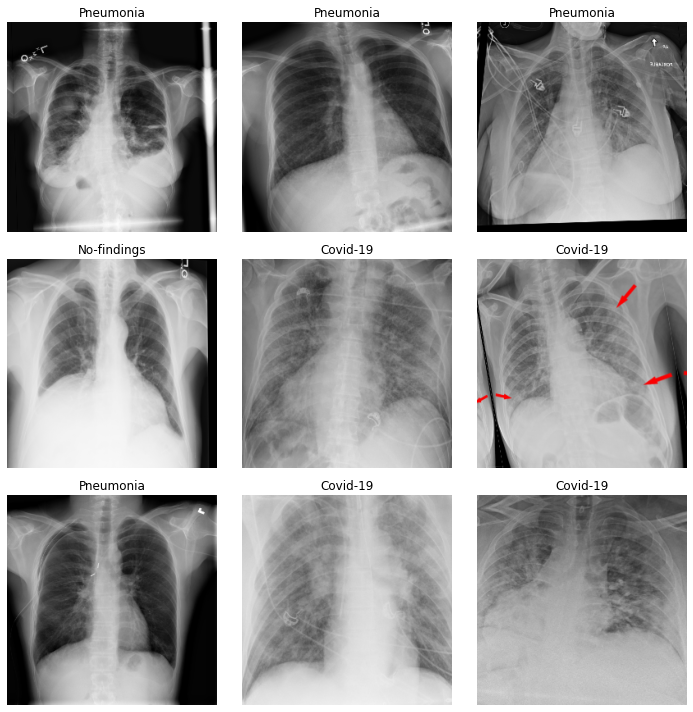

In [0]:
data.show_batch(rows=3, figsize=(10,10))

# **Model**

In [0]:
def convo2d(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.PReLU())
def convo2dx3(ni, nf):
    return nn.Sequential(
        convo2d(ni, nf),
        convo2d(nf, ni, size=1),  
        convo2d(ni, nf))
def convo2dx5(ni, nf):
    return nn.Sequential(
        convo2d(ni, nf),
        convo2d(nf, ni, size=1),  
        convo2d(ni, nf),
        convo2d(nf, ni, size=1),  
        convo2d(ni, nf))
  
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

model = nn.Sequential(
    convo2d(3, 8),
    maxpooling(),
    convo2d(8, 16),
    maxpooling(),
    convo2dx3(16, 32),
    maxpooling(),
    convo2dx5(32, 64),
    maxpooling(),
    convo2dx3(64, 128),
    maxpooling(),
    convo2dx5(128, 256), 
    maxpooling(), 
    convo2dx3(256, 256), 
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(243, 3)
    )

# **Training Phase**

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
print(learn.summary())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
PReLU                [8, 256, 256]        1          True      
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
PReLU                [16, 128, 128]       1          True      
___________________________________________________

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


# **Validation**

In [0]:
learn.fit_one_cycle(50, max_lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.581088,1.119554,0.365079,00:43
1,0.584985,0.613075,0.857143,00:42
2,0.552271,0.511300,0.841270,00:42
3,0.527307,0.528899,0.793651,00:42
4,0.499773,0.582340,0.777778,00:44
5,0.489947,1.250925,0.682540,00:44
6,0.470506,0.515416,0.857143,00:43
7,0.467173,0.528137,0.825397,00:43
8,0.448767,0.847378,0.746032,00:44
9,0.444074,1.407008,0.714286,00:48


Streaming output truncated to the last 5000 lines.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old beha

In [0]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
learn.fit_one_cycle(50, max_lr=0.0001)

epoch,train_loss,valid_loss,accuracy,time
0,0.120269,0.480228,0.857143,00:46
1,0.121678,0.476150,0.841270,00:43
2,0.142782,0.474830,0.857143,00:43
3,0.140740,0.478048,0.857143,00:44
4,0.134117,0.470002,0.857143,00:43
5,0.127201,0.485014,0.873016,00:43
6,0.126957,0.472175,0.873016,00:43
7,0.125049,0.412866,0.873016,00:43
8,0.125422,0.411661,0.857143,00:44
9,0.124464,0.454518,0.857143,00:43


Streaming output truncated to the last 5000 lines.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old beha

In [0]:
learn.export()

In [0]:
learn.fit_one_cycle(100, max_lr=0.001)

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(100, max_lr=0.0001)

In [0]:
learn.recorder.plot_losses()

# **Result and Conclusion**

### Trial 1: Epoch 50, Maximum learning rate 0.001

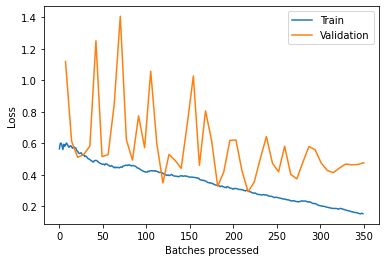

In [0]:
learn.recorder.plot_losses()

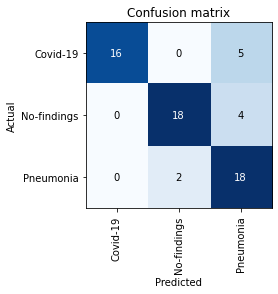

In [0]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

### Trial 3: Epoch 50, Maximum learning rate 0.0001

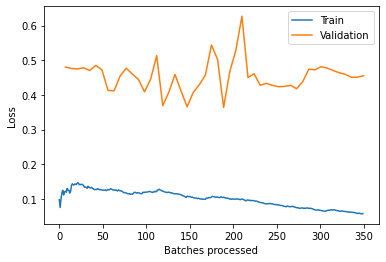

In [0]:
learn.recorder.plot_losses()

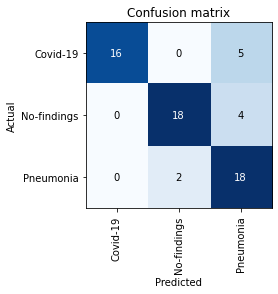

In [0]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

### Trial 2: Epoch 100, Maximum learning rate 0.001 (result in report)
### Trial 4: Epoch 100, Maximum learning rate 0.0001 (result in report)
